In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#custom
from quantum_layer import QuantumLayer

In [4]:
# Load flattened feature arrays for training
features_folder = "./../../features/training-a/flattened_arrays"

X_gray = np.load(f"{features_folder}/X_gray_8.npy")  # Grayscale image features
y_gray = np.load(f"{features_folder}/y_gray_8.npy")  # Grayscale labels
X_binary = np.load(f"{features_folder}/X_binary_8.npy")  # Grayscale image features
y_binary = np.load(f"{features_folder}/y_binary_8.npy")  # Grayscale labels

# Print shapes to check loading
print("Grayscale shape:", X_gray.shape)
print("Binary shape:", X_binary.shape)

Grayscale shape: (19702, 64)
Binary shape: (19702, 64)


In [5]:
scaler = MinMaxScaler()
X_gray_scaled = scaler.fit_transform(X_gray)
X_binary_scaled = scaler.fit_transform(X_binary)

# 4, 8, 12 features from PCA

In [6]:
# List of components to try
components_list = [4, 8, 12]

# Dictionaries to store results
X_gray_pca = {}
cumulative_variance_gray = {}
X_binary_pca = {}
cumulative_variance_binary = {}

for n in components_list:
    # -------------------- Grayscale --------------------
    pca_gray = PCA(n_components=n, random_state=42)
    X_gray_pca[n] = pca_gray.fit_transform(X_gray_scaled)
    cumulative_variance_gray[n] = np.cumsum(pca_gray.explained_variance_ratio_)
    
    # -------------------- Binary --------------------
    pca_binary = PCA(n_components=n, random_state=42)
    X_binary_pca[n] = pca_binary.fit_transform(X_binary_scaled)
    cumulative_variance_binary[n] = np.cumsum(pca_binary.explained_variance_ratio_)

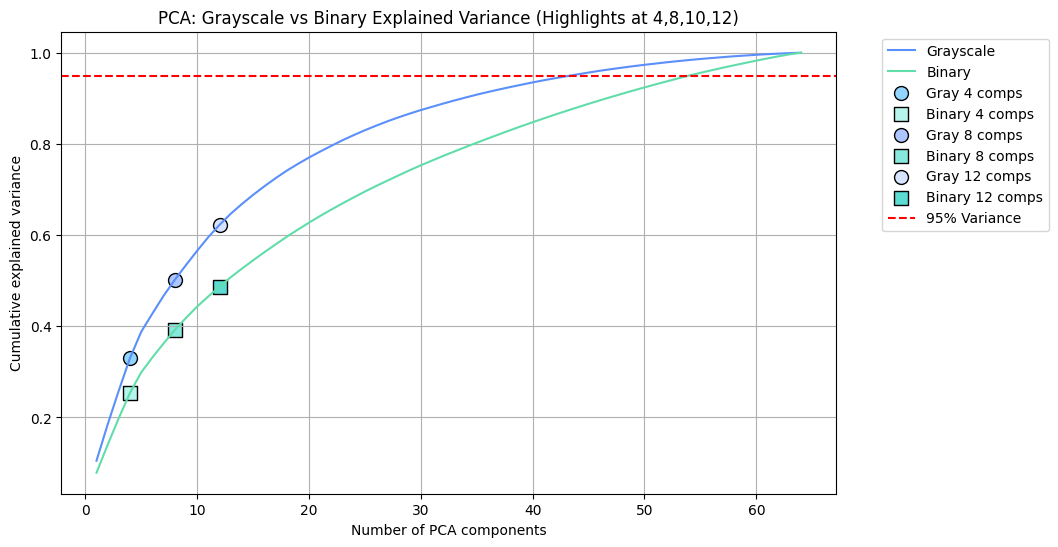

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Maximum number of components across datasets
max_components_gray = X_gray_scaled.shape[1]
max_components_binary = X_binary_scaled.shape[1]

# Fit PCA with max components
pca_gray_full = PCA(n_components=max_components_gray, random_state=42)
X_gray_pca_full = pca_gray_full.fit_transform(X_gray_scaled)
cumulative_variance_gray_full = np.cumsum(pca_gray_full.explained_variance_ratio_)

pca_binary_full = PCA(n_components=max_components_binary, random_state=42)
X_binary_pca_full = pca_binary_full.fit_transform(X_binary_scaled)
cumulative_variance_binary_full = np.cumsum(pca_binary_full.explained_variance_ratio_)

# Components to highlight
highlight = [4, 8, 12]

plt.figure(figsize=(10,6))

# Matte colors for full curves
plt.plot(range(1, max_components_gray+1), cumulative_variance_gray_full, label='Grayscale', color='#5B8FF9')  # soft blue
plt.plot(range(1, max_components_binary+1), cumulative_variance_binary_full, label='Binary', color='#61DDAA')  # soft green

# Matte colors for highlights
highlight_colors_gray = ['#91D5FF', '#ADC6FF', '#D6E4FF', '#E6F7FF']  # light muted blues
highlight_colors_binary = ['#B5F5EC', '#87E8DE', '#5CDBD3', '#36CFC9']  # light muted greens

for i, comp in enumerate(highlight):
    # Grayscale highlights
    plt.scatter(comp, cumulative_variance_gray_full[comp-1], color=highlight_colors_gray[i], s=100, marker='o', edgecolor='k', label=f'Gray {comp} comps')
    # Binary highlights
    plt.scatter(comp, cumulative_variance_binary_full[comp-1], color=highlight_colors_binary[i], s=100, marker='s', edgecolor='k', label=f'Binary {comp} comps')

# Horizontal line at 95% variance
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')

plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA: Grayscale vs Binary Explained Variance (Highlights at 4,8,10,12)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

components_list = [4, 8, 12]

# Dictionaries to store train-test splits
X_train_gray_dict, X_test_gray_dict = {}, {}
y_train_gray_dict, y_test_gray_dict = {}, {}

X_train_binary_dict, X_test_binary_dict = {}, {}
y_train_binary_dict, y_test_binary_dict = {}, {}

for n in components_list:
    # Grayscale
    X_train_gray_dict[n], X_test_gray_dict[n], y_train_gray_dict[n], y_test_gray_dict[n] = train_test_split(
        X_gray_pca[n],
        y_gray,
        test_size=0.2,
        random_state=42,
        stratify=y_gray
    )
    
    # Binary
    X_train_binary_dict[n], X_test_binary_dict[n], y_train_binary_dict[n], y_test_binary_dict[n] = train_test_split(
        X_binary_pca[n],
        y_binary,
        test_size=0.2,
        random_state=42,
        stratify=y_binary
    )

In [10]:
import torch

components_list = [4, 8, 12]

# Dictionaries to store PyTorch tensors
X_train_gray_t_dict, X_test_gray_t_dict = {}, {}
y_train_gray_t_dict, y_test_gray_np_dict = {}, {}

X_train_binary_t_dict, X_test_binary_t_dict = {}, {}
y_train_binary_t_dict, y_test_binary_np_dict = {}, {}

for n in components_list:
    # -------------------- Grayscale --------------------
    X_train_gray_t_dict[n] = torch.tensor(X_train_gray_dict[n], dtype=torch.float32)
    y_train_gray_t_dict[n] = torch.tensor(y_train_gray_dict[n], dtype=torch.long)
    X_test_gray_t_dict[n] = torch.tensor(X_test_gray_dict[n], dtype=torch.float32)
    y_test_gray_np_dict[n] = y_test_gray_dict[n]  # Keep as NumPy array for metrics

    # -------------------- Binary --------------------
    X_train_binary_t_dict[n] = torch.tensor(X_train_binary_dict[n], dtype=torch.float32)
    y_train_binary_t_dict[n] = torch.tensor(y_train_binary_dict[n], dtype=torch.long)
    X_test_binary_t_dict[n] = torch.tensor(X_test_binary_dict[n], dtype=torch.float32)
    y_test_binary_np_dict[n] = y_test_binary_dict[n]  # Keep as NumPy array for metrics

In [13]:
import torch.nn as nn

# Dictionaries to store models for each component count
models_gray = {}
models_binary = {}

components_list = [4, 8, 12]  # Ensure this matches your data preparation

for n in components_list:
    # -------------------- Grayscale Models --------------------
    models_gray[n] = nn.Sequential(
        QuantumLayer(n_qubits=n),   # Dynamic number of qubits
        nn.Linear(n, 16),           # Input size matches n_qubits
        nn.ReLU(),
        nn.Linear(16, 10)           # Output classes
    )

    # -------------------- Binary Models --------------------
    models_binary[n] = nn.Sequential(
        QuantumLayer(n_qubits=n),   # Dynamic number of qubits
        nn.Linear(n, 16),           # Input size matches n_qubits
        nn.ReLU(),
        nn.Linear(16, 10)           # Output classes
    )

    print(f"Created models for n={n}")
    print(f"Gray Model Structure (n={n}):\n{models_gray[n]}\n")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Created models for n=4
Gray Model Structure (n=4):
Sequential(
  (0): QuantumLayer(
    (q_layer): TorchConnector()
  )
  (1): Linear(in_features=4, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)

Created models for n=8
Gray Model Structure (n=8):
Sequential(
  (0): QuantumLayer(
    (q_layer): TorchConnector()
  )
  (1): Linear(in_features=8, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)

Created models for n=12
Gray Model Structure (n=12):
Sequential(
  (0): QuantumLayer(
    (q_layer): TorchConnector()
  )
  (1): Linear(in_features=12, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)



## greyscale

In [12]:
X_train_t = X_train_gray_t
y_train_t = y_train_gray_t
X_test_t = X_test_gray_t
y_test_np = y_test_gray_np
model = model_gray

NameError: name 'X_train_gray_t' is not defined

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:17<00:00,  1.53s/it]


Epoch 1/10 — Train Loss: 1.6589, Train Acc: 40.87% | Val Loss: 1.6961, Val Acc: 38.39% | Test Loss: 1.6704, Test Acc: 40.35%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [13:26<00:00,  1.82s/it]


Epoch 2/10 — Train Loss: 1.6579, Train Acc: 40.92% | Val Loss: 1.6956, Val Acc: 38.64% | Test Loss: 1.6695, Test Acc: 40.29%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [10:55<00:00,  1.48s/it]


Epoch 3/10 — Train Loss: 1.6577, Train Acc: 40.95% | Val Loss: 1.6951, Val Acc: 38.77% | Test Loss: 1.6686, Test Acc: 40.42%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [10:38<00:00,  1.44s/it]


Epoch 4/10 — Train Loss: 1.6574, Train Acc: 40.88% | Val Loss: 1.6925, Val Acc: 38.96% | Test Loss: 1.6686, Test Acc: 40.57%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:01<00:00,  1.49s/it]


Epoch 5/10 — Train Loss: 1.6573, Train Acc: 40.99% | Val Loss: 1.6921, Val Acc: 38.64% | Test Loss: 1.6687, Test Acc: 40.85%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:17<00:00,  1.53s/it]


Epoch 6/10 — Train Loss: 1.6567, Train Acc: 41.16% | Val Loss: 1.6906, Val Acc: 39.21% | Test Loss: 1.6683, Test Acc: 40.42%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:16<00:00,  1.52s/it]


Epoch 7/10 — Train Loss: 1.6574, Train Acc: 41.11% | Val Loss: 1.6904, Val Acc: 38.71% | Test Loss: 1.6697, Test Acc: 40.29%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:38<00:00,  1.57s/it]


Epoch 8/10 — Train Loss: 1.6569, Train Acc: 40.85% | Val Loss: 1.6921, Val Acc: 38.77% | Test Loss: 1.6690, Test Acc: 40.60%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:36<00:00,  1.57s/it]


Epoch 9/10 — Train Loss: 1.6563, Train Acc: 40.99% | Val Loss: 1.6924, Val Acc: 39.40% | Test Loss: 1.6689, Test Acc: 40.24%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 444/444 [11:28<00:00,  1.55s/it]


Epoch 10/10 — Train Loss: 1.6569, Train Acc: 40.82% | Val Loss: 1.6902, Val Acc: 39.09% | Test Loss: 1.6684, Test Acc: 40.83%


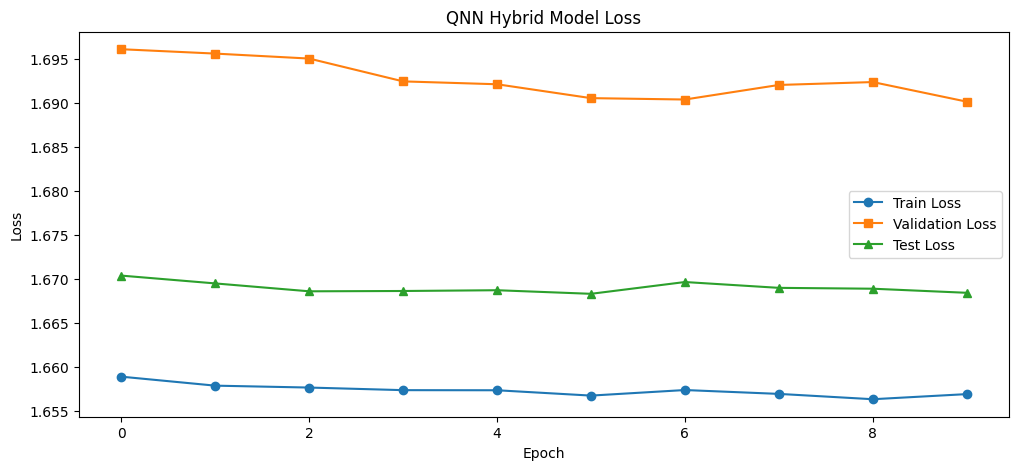

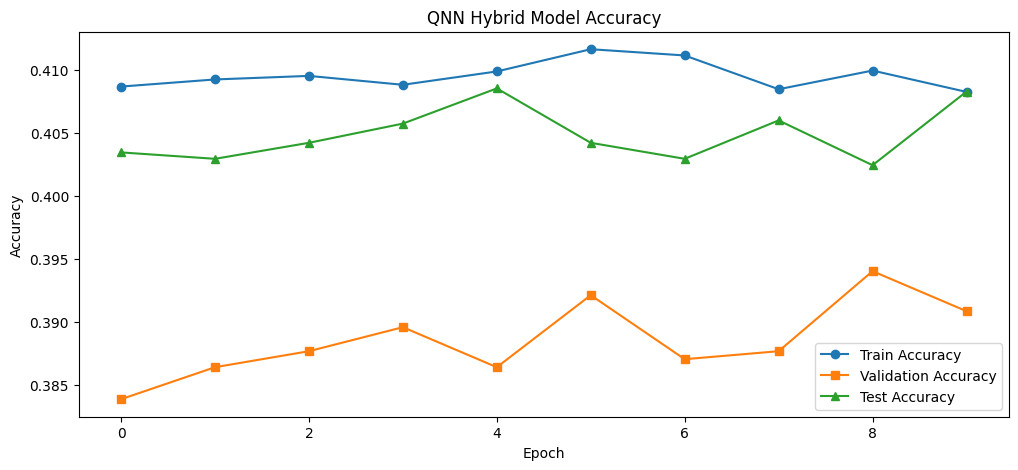

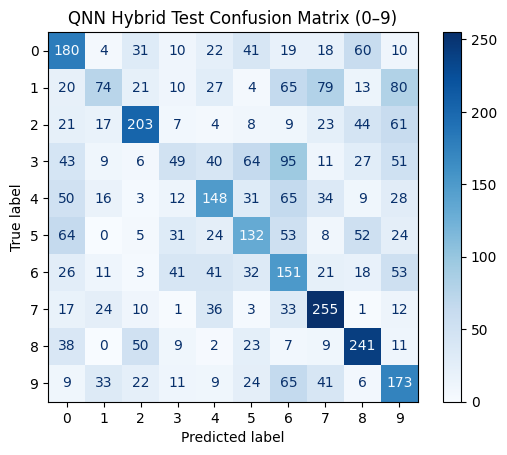

In [13]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# -------------------- Training Setup --------------------
epochs = 10
batch_size = 32
lr = 0.01
checkpoint = "checkpoint.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Validation split (10% of training data)
num_samples = X_train_t.shape[0]
val_ratio = 0.1
val_size = int(val_ratio * num_samples)
X_val_t = X_train_t[:val_size]
y_val_t = y_train_t[:val_size]
X_train_t_new = X_train_t[val_size:]
y_train_t_new = y_train_t[val_size:]
num_train_samples = X_train_t_new.shape[0]

# Resume from checkpoint if exists
if os.path.exists(checkpoint):
    checkpoint_data = torch.load(checkpoint)
    model.load_state_dict(checkpoint_data["model_state"])
    optimizer.load_state_dict(checkpoint_data["optimizer_state"])
    train_losses = checkpoint_data["train_losses"]
    val_losses = checkpoint_data["val_losses"]
    test_losses = checkpoint_data["test_losses"]
    train_accs = checkpoint_data["train_accs"]
    val_accs = checkpoint_data["val_accs"]
    test_accs = checkpoint_data["test_accs"]
    start_epoch = checkpoint_data["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 1

# -------------------- Training Loop --------------------
for ep in range(start_epoch, epochs + 1):
    model.train()
    epoch_loss = 0

    for i in tqdm(range(0, num_train_samples, batch_size), desc=f"Epoch {ep}/{epochs}"):
        X_batch = X_train_t_new[i:i + batch_size]
        y_batch = y_train_t_new[i:i + batch_size]

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / (num_train_samples // batch_size)
    train_losses.append(avg_train_loss)

    # Compute training accuracy
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_t_new).argmax(dim=1).numpy()
    train_acc = accuracy_score(y_train_t_new.numpy(), train_preds)
    train_accs.append(train_acc)

    # -------------------- Validation --------------------
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = loss_fn(val_logits, y_val_t).item()
        val_preds = val_logits.argmax(dim=1).numpy()
        val_acc = accuracy_score(y_val_t.numpy(), val_preds)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # -------------------- Test --------------------
    with torch.no_grad():
        test_logits = model(X_test_t)
        test_loss = loss_fn(test_logits, torch.tensor(y_test_np, dtype=torch.long)).item()
        test_preds = test_logits.argmax(dim=1).numpy()
        test_acc = accuracy_score(y_test_np, test_preds)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {ep}/{epochs} — "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    # Save checkpoint
    torch.save({
        "epoch": ep,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_accs": test_accs
    }, checkpoint)

# -------------------- Plotting --------------------
plt.figure(figsize=(12,5))
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='s', label='Validation Loss')
plt.plot(test_losses, marker='^', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("QNN Hybrid Model Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(train_accs, marker='o', label='Train Accuracy')
plt.plot(val_accs, marker='s', label='Validation Accuracy')
plt.plot(test_accs, marker='^', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("QNN Hybrid Model Accuracy")
plt.legend()
plt.show()

# -------------------- Final Test Confusion Matrix --------------------
model.eval()
with torch.no_grad():
    final_test_preds = model(X_test_t).argmax(dim=1).numpy()

cm = confusion_matrix(y_test_np, final_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("QNN Hybrid Test Confusion Matrix (0–9)")
plt.show()


==================== Training Gray_Model_n4 ====================


Epoch 1 — Train Loss: 1.7978 | Val Acc: 39.15% | Test Acc: 38.82%


Epoch 2 — Train Loss: 1.6856 | Val Acc: 38.90% | Test Acc: 39.63%


Epoch 3 — Train Loss: 1.6709 | Val Acc: 39.40% | Test Acc: 40.35%


Epoch 4 — Train Loss: 1.6633 | Val Acc: 39.91% | Test Acc: 40.35%


Epoch 5 — Train Loss: 1.6587 | Val Acc: 39.85% | Test Acc: 40.57%


Epoch 6 — Train Loss: 1.6557 | Val Acc: 40.61% | Test Acc: 40.35%


Epoch 7 — Train Loss: 1.6546 | Val Acc: 40.55% | Test Acc: 40.07%


Epoch 8 — Train Loss: 1.6532 | Val Acc: 40.23% | Test Acc: 39.76%


Epoch 9 — Train Loss: 1.6521 | Val Acc: 40.10% | Test Acc: 40.17%


Epoch 10 — Train Loss: 1.6509 | Val Acc: 39.91% | Test Acc: 39.99%


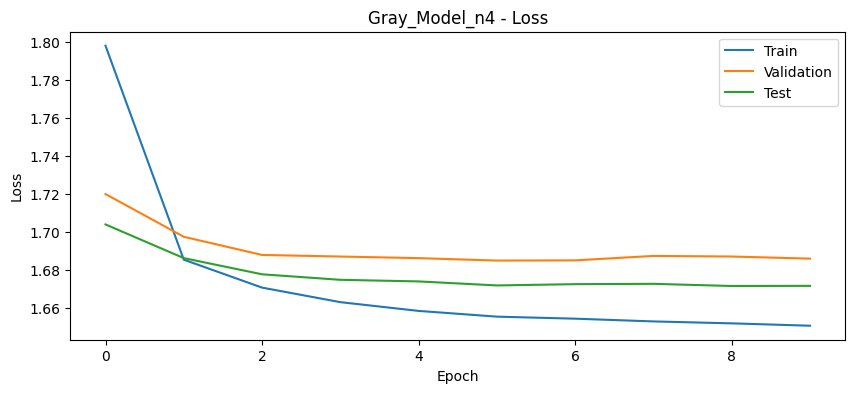

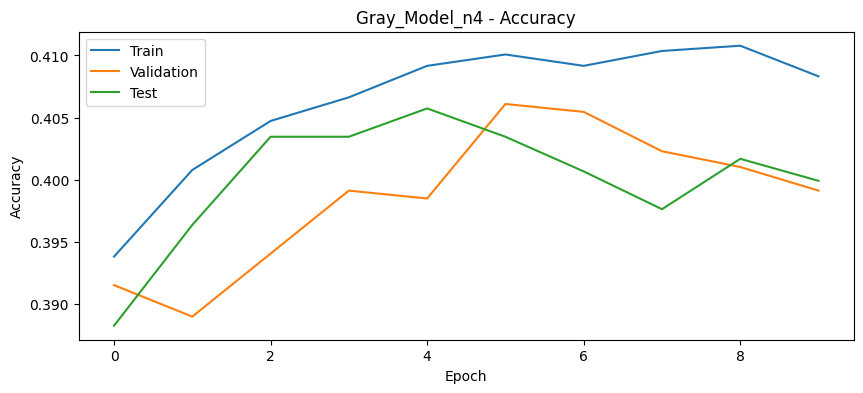

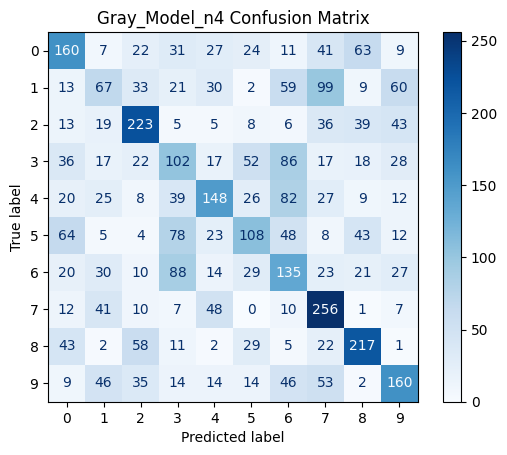


==================== Training Binary_Model_n4 ====================


Epoch 1 — Train Loss: 2.2112 | Val Acc: 20.37% | Test Acc: 20.27%


Epoch 2 — Train Loss: 2.1692 | Val Acc: 20.05% | Test Acc: 20.98%


Epoch 3 — Train Loss: 2.1640 | Val Acc: 20.24% | Test Acc: 21.44%


Epoch 4 — Train Loss: 2.1620 | Val Acc: 19.80% | Test Acc: 21.34%


Epoch 5 — Train Loss: 2.1614 | Val Acc: 20.11% | Test Acc: 21.34%


Epoch 6 — Train Loss: 2.1604 | Val Acc: 20.30% | Test Acc: 21.47%


Epoch 7 — Train Loss: 2.1598 | Val Acc: 19.86% | Test Acc: 21.82%


Epoch 8 — Train Loss: 2.1593 | Val Acc: 20.49% | Test Acc: 21.54%


Epoch 9 — Train Loss: 2.1590 | Val Acc: 20.56% | Test Acc: 21.85%


Epoch 10 — Train Loss: 2.1595 | Val Acc: 20.49% | Test Acc: 21.37%


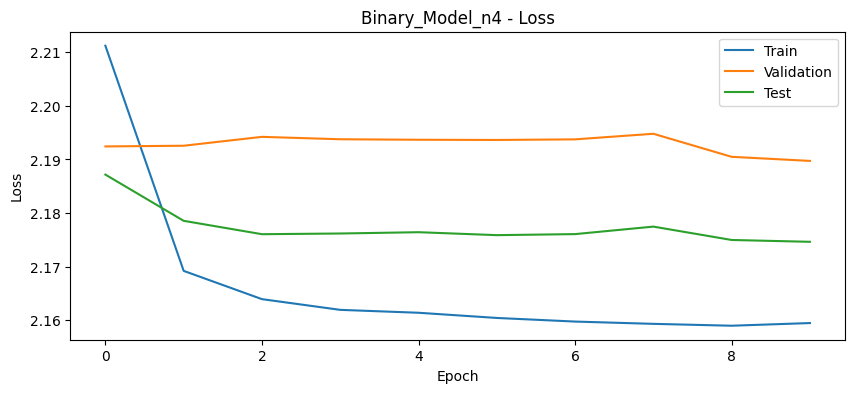

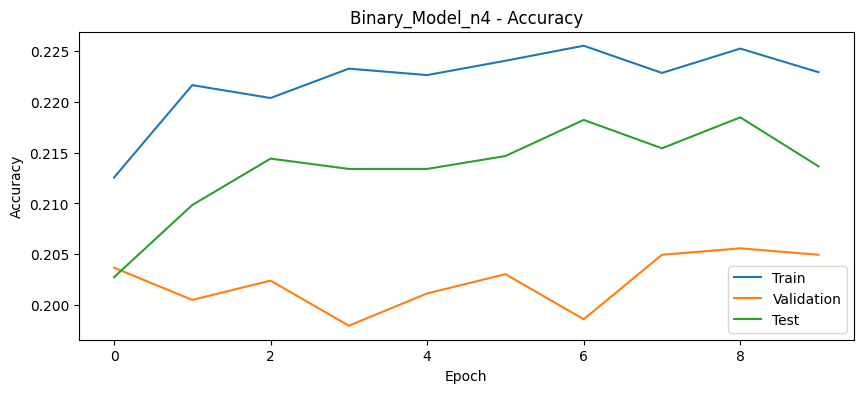

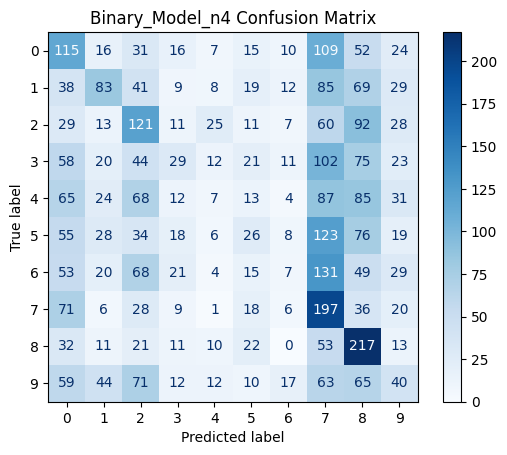


==================== Training Gray_Model_n8 ====================


Epoch 1 — Train Loss: 1.8169 | Val Acc: 42.77% | Test Acc: 44.08%


Epoch 2 — Train Loss: 1.6201 | Val Acc: 45.62% | Test Acc: 45.90%


Epoch 3 — Train Loss: 1.5879 | Val Acc: 46.00% | Test Acc: 46.31%


Epoch 4 — Train Loss: 1.5729 | Val Acc: 47.21% | Test Acc: 46.61%


Epoch 5 — Train Loss: 1.5642 | Val Acc: 46.83% | Test Acc: 47.22%


Epoch 6 — Train Loss: 1.5543 | Val Acc: 47.53% | Test Acc: 47.55%


Epoch 7 — Train Loss: 1.5455 | Val Acc: 47.46% | Test Acc: 47.91%


Epoch 8 — Train Loss: 1.5399 | Val Acc: 46.95% | Test Acc: 48.06%


Epoch 9 — Train Loss: 1.5352 | Val Acc: 46.89% | Test Acc: 48.57%


Epoch 10 — Train Loss: 1.5318 | Val Acc: 47.14% | Test Acc: 48.57%


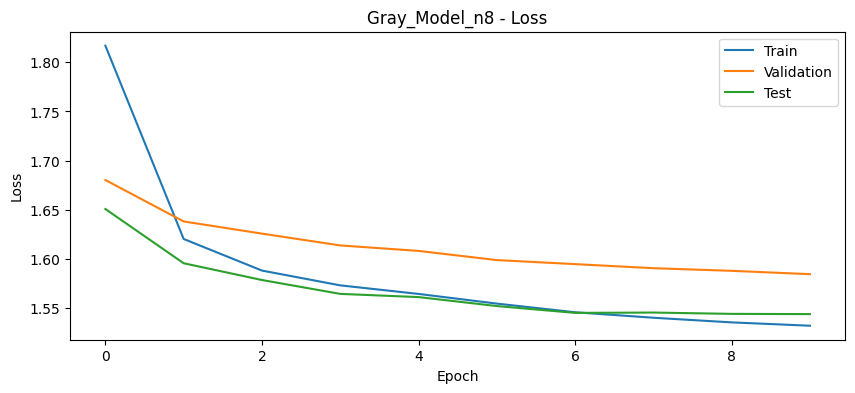

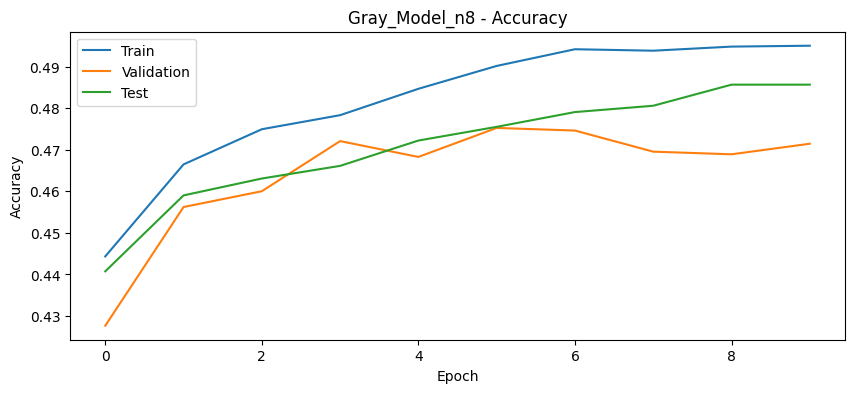

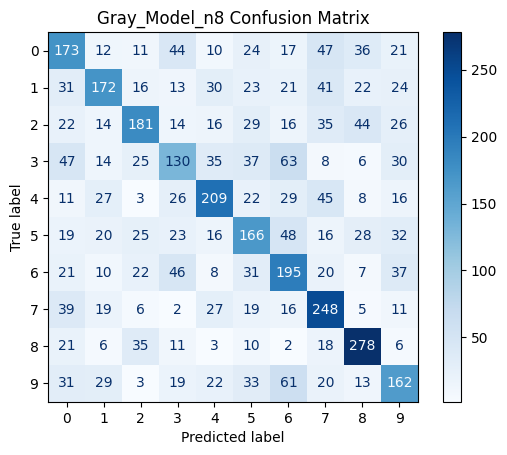


==================== Training Binary_Model_n8 ====================


Epoch 1 — Train Loss: 2.1913 | Val Acc: 20.88% | Test Acc: 21.54%


Epoch 2 — Train Loss: 2.1353 | Val Acc: 22.78% | Test Acc: 22.86%


Epoch 3 — Train Loss: 2.1196 | Val Acc: 21.70% | Test Acc: 23.24%


Epoch 4 — Train Loss: 2.1123 | Val Acc: 22.34% | Test Acc: 23.67%


Epoch 5 — Train Loss: 2.1074 | Val Acc: 23.22% | Test Acc: 23.90%


Epoch 6 — Train Loss: 2.1038 | Val Acc: 22.97% | Test Acc: 23.90%


Epoch 7 — Train Loss: 2.1016 | Val Acc: 22.84% | Test Acc: 23.65%


Epoch 8 — Train Loss: 2.0993 | Val Acc: 22.91% | Test Acc: 23.70%


Epoch 9 — Train Loss: 2.0972 | Val Acc: 23.22% | Test Acc: 23.90%


Epoch 10 — Train Loss: 2.0944 | Val Acc: 23.22% | Test Acc: 24.33%


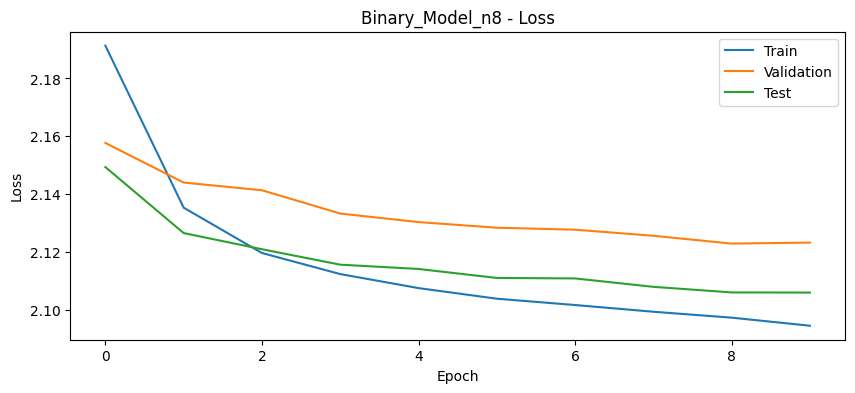

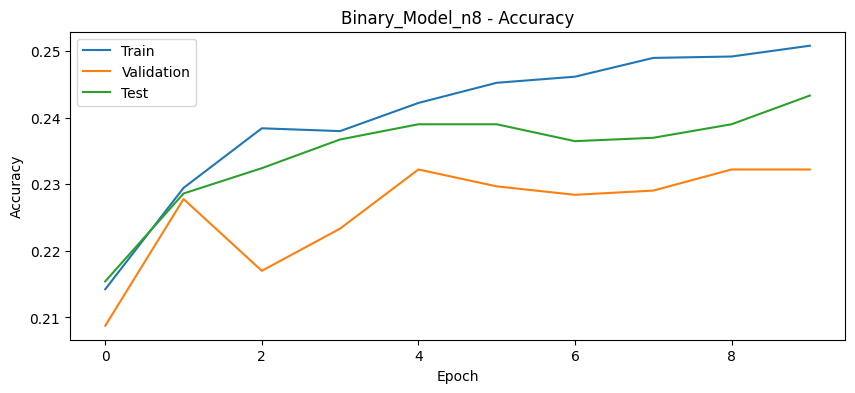

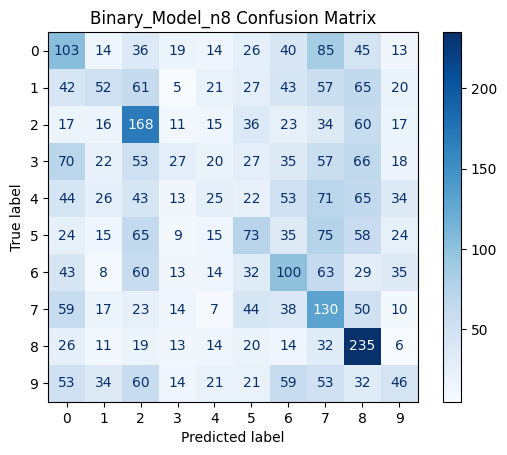


==================== Training Gray_Model_n12 ====================


KeyboardInterrupt: 

In [14]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# ==========================================
# 1. Define the Reusable Training Function
# ==========================================
def train_and_evaluate(model, X_train_t, y_train_t, X_test_t, y_test_np, model_name, epochs=10, batch_size=32, lr=0.01):
    print(f"\n{'='*20} Training {model_name} {'='*20}")
    
    # Checkpoint name specific to this model
    checkpoint_path = f"checkpoint_{model_name}.pth"
    
    # Initialize lists & Optimizer
    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Validation split (10% of training data)
    num_samples = X_train_t.shape[0]
    val_ratio = 0.1
    val_size = int(val_ratio * num_samples)
    
    # Split tensors
    X_val_t = X_train_t[:val_size]
    y_val_t = y_train_t[:val_size]
    X_train_t_new = X_train_t[val_size:]
    y_train_t_new = y_train_t[val_size:]
    
    num_train_samples = X_train_t_new.shape[0]

    # Resume logic
    start_epoch = 1
    if os.path.exists(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data["model_state"])
        optimizer.load_state_dict(checkpoint_data["optimizer_state"])
        train_losses = checkpoint_data["train_losses"]
        val_losses = checkpoint_data["val_losses"]
        test_losses = checkpoint_data["test_losses"]
        train_accs = checkpoint_data["train_accs"]
        val_accs = checkpoint_data["val_accs"]
        test_accs = checkpoint_data["test_accs"]
        start_epoch = checkpoint_data["epoch"] + 1
        print(f"Resuming {model_name} from epoch {start_epoch}")

    # -------------------- Training Loop --------------------
    for ep in range(start_epoch, epochs + 1):
        model.train()
        epoch_loss = 0

        # Create batches
        for i in tqdm(range(0, num_train_samples, batch_size), desc=f"{model_name} Epoch {ep}/{epochs}", leave=False):
            X_batch = X_train_t_new[i:i + batch_size]
            y_batch = y_train_t_new[i:i + batch_size]

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / (num_train_samples // batch_size)
        train_losses.append(avg_train_loss)

        # -------------------- Evaluation --------------------
        model.eval()
        with torch.no_grad():
            # Train metrics
            train_preds = model(X_train_t_new).argmax(dim=1).numpy()
            train_acc = accuracy_score(y_train_t_new.numpy(), train_preds)
            
            # Validation metrics
            val_logits = model(X_val_t)
            val_loss = loss_fn(val_logits, y_val_t).item()
            val_preds = val_logits.argmax(dim=1).numpy()
            val_acc = accuracy_score(y_val_t.numpy(), val_preds)
            
            # Test metrics (Using passed NumPy y_test for acc, Tensor for loss)
            test_logits = model(X_test_t)
            test_loss = loss_fn(test_logits, torch.tensor(y_test_np, dtype=torch.long)).item()
            test_preds = test_logits.argmax(dim=1).numpy()
            test_acc = accuracy_score(y_test_np, test_preds)

        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {ep} — Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

        # Save checkpoint
        torch.save({
            "epoch": ep,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_losses": train_losses, "val_losses": val_losses, "test_losses": test_losses,
            "train_accs": train_accs, "val_accs": val_accs, "test_accs": test_accs
        }, checkpoint_path)

    # -------------------- Plotting --------------------
    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.plot(test_losses, label='Test')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.plot(test_accs, label='Test')
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, test_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# ==========================================
# 2. Main Loop to Run All Models
# ==========================================

# Assuming components_list = [4, 8, 12] and dictionaries are populated
for n in components_list:
    
    # --- Run Grayscale Model ---
    train_and_evaluate(
        model=models_gray[n],
        X_train_t=X_train_gray_t_dict[n],
        y_train_t=y_train_gray_t_dict[n],
        X_test_t=X_test_gray_t_dict[n],
        y_test_np=y_test_gray_np_dict[n],
        model_name=f"Gray_Model_n{n}"
    )

    # --- Run Binary Model ---
    train_and_evaluate(
        model=models_binary[n],
        X_train_t=X_train_binary_t_dict[n],
        y_train_t=y_train_binary_t_dict[n],
        X_test_t=X_test_binary_t_dict[n],
        y_test_np=y_test_binary_np_dict[n],
        model_name=f"Binary_Model_n{n}"
    )

## umap 4 dimension

In [2]:
# Load flattened feature arrays for training
features_folder = "./../features/training-a/umap"

X = np.load(f"{features_folder}/X_gray_umap.npy")  # Grayscale image features
y = np.load(f"{features_folder}/y_gray.npy")  # Grayscale labels

# Print shapes to check loading
print("Grayscale shape:", X.shape)

Grayscale shape: (19702, 4)


In [3]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# --------- Split data into training and testing sets ---------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,               # Features
    y,                   # Labels
    test_size=0.2,            # 20% for testing
    random_state=42,          # For reproducibility
    stratify=y           # Preserve label distribution
)

In [5]:
# --------- Convert data to PyTorch tensors ---------
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # Features as float tensors
y_train_t = torch.tensor(y_train, dtype=torch.long)     # Labels as long tensors
X_test_t = torch.tensor(X_test, dtype=torch.float32)    # Test features as float tensors
y_test_np = y_test

In [6]:
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# --------- Define a quantum layer for 4 features (4 qubits) ---------
class QuantumLayer4(nn.Module):
    def __init__(self):
        super().__init__()
        n = 4  # Number of qubits = number of features

        # Parameter vectors for encoding input features and variational angles
        self.x_params     = ParameterVector("x", n)
        self.theta_params = ParameterVector("θ", n)

        # Build quantum circuit
        qc = QuantumCircuit(n)
        
        # Angle-encode each feature into a qubit using Ry rotations
        for i in range(n):
            qc.ry(self.x_params[i] * np.pi, i)
        
        # Chain entanglement using CNOT gates
        for i in range(n-1):
            qc.cx(i, i+1)
        
        # Variational layer: one Ry rotation per qubit
        for i in range(n):
            qc.ry(self.theta_params[i], i)

        # Define one Z observable per qubit → 4 outputs
        observables = [
            SparsePauliOp.from_list([("I"*i + "Z" + "I"*(n-i-1), 1.0)])
            for i in range(n)
        ]

        # Wrap the circuit into an EstimatorQNN and connect it to PyTorch
        qnn = EstimatorQNN(
            circuit=qc,
            input_params=list(self.x_params),
            weight_params=list(self.theta_params),
            observables=observables,
            estimator=StatevectorEstimator()
        )
        self.qlayer = TorchConnector(qnn)

    def forward(self, x):
        """
        Forward pass through the quantum layer.
        Input x: [batch_size, 4] → Output: [batch_size, 4]
        """
        return self.qlayer(x)


In [7]:
import torch.nn as nn

# --------- Define hybrid models (quantum + classical) ---------

model = nn.Sequential(
    QuantumLayer4(),   # Quantum layer: input [batch, 4], output [batch, 4]
    nn.Linear(4, 16),  # Classical fully connected layer (input=4)
    nn.ReLU(),          # Non-linear activation
    nn.Linear(16, 10)  # Output layer for 10 classes
)

# Print model architecture
print(model)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Sequential(
  (0): QuantumLayer4(
    (qlayer): TorchConnector()
  )
  (1): Linear(in_features=4, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# -------------------- Training Setup --------------------
epochs = 20
batch_size = 32
lr = 0.01
checkpoint = "checkpoint.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Validation split (10% of training data)
num_samples = X_train_t.shape[0]
val_ratio = 0.1
val_size = int(val_ratio * num_samples)
X_val_t = X_train_t[:val_size]
y_val_t = y_train_t[:val_size]
X_train_t_new = X_train_t[val_size:]
y_train_t_new = y_train_t[val_size:]
num_train_samples = X_train_t_new.shape[0]

# Resume from checkpoint if exists
if os.path.exists(checkpoint):
    checkpoint_data = torch.load(checkpoint)
    model.load_state_dict(checkpoint_data["model_state"])
    optimizer.load_state_dict(checkpoint_data["optimizer_state"])
    train_losses = checkpoint_data["train_losses"]
    val_losses = checkpoint_data["val_losses"]
    test_losses = checkpoint_data["test_losses"]
    train_accs = checkpoint_data["train_accs"]
    val_accs = checkpoint_data["val_accs"]
    test_accs = checkpoint_data["test_accs"]
    start_epoch = checkpoint_data["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 1

# -------------------- Training Loop --------------------
for ep in range(start_epoch, epochs + 1):
    model.train()
    epoch_loss = 0

    for i in tqdm(range(0, num_train_samples, batch_size), desc=f"Epoch {ep}/{epochs}"):
        X_batch = X_train_t_new[i:i + batch_size]
        y_batch = y_train_t_new[i:i + batch_size]

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / (num_train_samples // batch_size)
    train_losses.append(avg_train_loss)

    # Compute training accuracy
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_t_new).argmax(dim=1).numpy()
    train_acc = accuracy_score(y_train_t_new.numpy(), train_preds)
    train_accs.append(train_acc)

    # -------------------- Validation --------------------
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = loss_fn(val_logits, y_val_t).item()
        val_preds = val_logits.argmax(dim=1).numpy()
        val_acc = accuracy_score(y_val_t.numpy(), val_preds)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # -------------------- Test --------------------
    with torch.no_grad():
        test_logits = model(X_test_t)
        test_loss = loss_fn(test_logits, torch.tensor(y_test_np, dtype=torch.long)).item()
        test_preds = test_logits.argmax(dim=1).numpy()
        test_acc = accuracy_score(y_test_np, test_preds)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {ep}/{epochs} — "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    # Save checkpoint
    torch.save({
        "epoch": ep,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_accs": test_accs
    }, checkpoint)

# -------------------- Plotting --------------------
plt.figure(figsize=(12,5))
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='s', label='Validation Loss')
plt.plot(test_losses, marker='^', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("QNN Hybrid Model Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(train_accs, marker='o', label='Train Accuracy')
plt.plot(val_accs, marker='s', label='Validation Accuracy')
plt.plot(test_accs, marker='^', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("QNN Hybrid Model Accuracy")
plt.legend()
plt.show()

# -------------------- Final Test Confusion Matrix --------------------
model.eval()
with torch.no_grad():
    final_test_preds = model(X_test_t).argmax(dim=1).numpy()

cm = confusion_matrix(y_test_np, final_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("QNN Hybrid Test Confusion Matrix (0–9)")
plt.show()

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [11:07<00:00,  1.50s/it]


Epoch 1/20 — Train Loss: 0.6611, Train Acc: 88.31% | Val Loss: 0.4502, Val Acc: 87.94% | Test Loss: 0.4098, Test Acc: 88.45%


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [13:51<00:00,  1.87s/it]


Epoch 2/20 — Train Loss: 0.3454, Train Acc: 90.05% | Val Loss: 0.4153, Val Acc: 89.97% | Test Loss: 0.3713, Test Acc: 89.95%


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [16:55<00:00,  2.29s/it]


Epoch 3/20 — Train Loss: 0.3218, Train Acc: 91.05% | Val Loss: 0.3952, Val Acc: 90.61% | Test Loss: 0.3529, Test Acc: 91.04%


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [17:27<00:00,  2.36s/it]


Epoch 4/20 — Train Loss: 0.3093, Train Acc: 91.60% | Val Loss: 0.3867, Val Acc: 91.37% | Test Loss: 0.3465, Test Acc: 91.42%


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [16:55<00:00,  2.29s/it]


Epoch 5/20 — Train Loss: 0.3017, Train Acc: 91.64% | Val Loss: 0.3872, Val Acc: 90.04% | Test Loss: 0.3449, Test Acc: 91.50%


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [13:17<00:00,  1.80s/it]


Epoch 6/20 — Train Loss: 0.2969, Train Acc: 91.95% | Val Loss: 0.3784, Val Acc: 91.05% | Test Loss: 0.3362, Test Acc: 91.73%


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [15:04<00:00,  2.04s/it]


Epoch 7/20 — Train Loss: 0.2899, Train Acc: 92.37% | Val Loss: 0.3695, Val Acc: 91.18% | Test Loss: 0.3305, Test Acc: 92.29%


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [17:21<00:00,  2.35s/it]


Epoch 8/20 — Train Loss: 0.2865, Train Acc: 92.10% | Val Loss: 0.3731, Val Acc: 91.37% | Test Loss: 0.3324, Test Acc: 91.75%


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 444/444 [12:44<00:00,  1.72s/it]


Epoch 9/20 — Train Loss: 0.2847, Train Acc: 92.41% | Val Loss: 0.3635, Val Acc: 91.69% | Test Loss: 0.3262, Test Acc: 92.34%


Epoch 10/20:  14%|█████████▎                                                          | 61/444 [01:43<10:43,  1.68s/it]

Resuming training from epoch 10


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [17:18<00:00,  2.34s/it]


Epoch 10/20 — Train Loss: 0.2818, Train Acc: 91.87% | Val Loss: 0.3656, Val Acc: 91.50% | Test Loss: 0.3317, Test Acc: 91.70%


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [19:18<00:00,  2.61s/it]


Epoch 11/20 — Train Loss: 0.2795, Train Acc: 92.62% | Val Loss: 0.3551, Val Acc: 92.01% | Test Loss: 0.3199, Test Acc: 92.24%


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [18:45<00:00,  2.54s/it]


Epoch 12/20 — Train Loss: 0.2765, Train Acc: 92.81% | Val Loss: 0.3462, Val Acc: 92.01% | Test Loss: 0.3158, Test Acc: 92.41%


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [17:07<00:00,  2.31s/it]


Epoch 13/20 — Train Loss: 0.2728, Train Acc: 92.72% | Val Loss: 0.3445, Val Acc: 92.58% | Test Loss: 0.3165, Test Acc: 92.24%


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [13:39<00:00,  1.84s/it]


Epoch 14/20 — Train Loss: 0.2718, Train Acc: 92.44% | Val Loss: 0.3524, Val Acc: 91.24% | Test Loss: 0.3159, Test Acc: 92.13%


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [10:37<00:00,  1.43s/it]


Epoch 15/20 — Train Loss: 0.2674, Train Acc: 92.56% | Val Loss: 0.3451, Val Acc: 91.94% | Test Loss: 0.3128, Test Acc: 92.31%


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [11:04<00:00,  1.50s/it]


Epoch 16/20 — Train Loss: 0.2675, Train Acc: 92.87% | Val Loss: 0.3442, Val Acc: 92.70% | Test Loss: 0.3108, Test Acc: 92.64%


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [10:37<00:00,  1.44s/it]


Epoch 17/20 — Train Loss: 0.2662, Train Acc: 92.62% | Val Loss: 0.3440, Val Acc: 91.75% | Test Loss: 0.3136, Test Acc: 92.03%


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [10:37<00:00,  1.43s/it]


Epoch 18/20 — Train Loss: 0.2622, Train Acc: 92.33% | Val Loss: 0.3491, Val Acc: 91.24% | Test Loss: 0.3143, Test Acc: 91.96%


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [10:38<00:00,  1.44s/it]


Epoch 19/20 — Train Loss: 0.2614, Train Acc: 93.20% | Val Loss: 0.3278, Val Acc: 92.20% | Test Loss: 0.3028, Test Acc: 92.64%


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 444/444 [10:37<00:00,  1.44s/it]


Epoch 20/20 — Train Loss: 0.2591, Train Acc: 92.60% | Val Loss: 0.3336, Val Acc: 92.07% | Test Loss: 0.3067, Test Acc: 92.34%


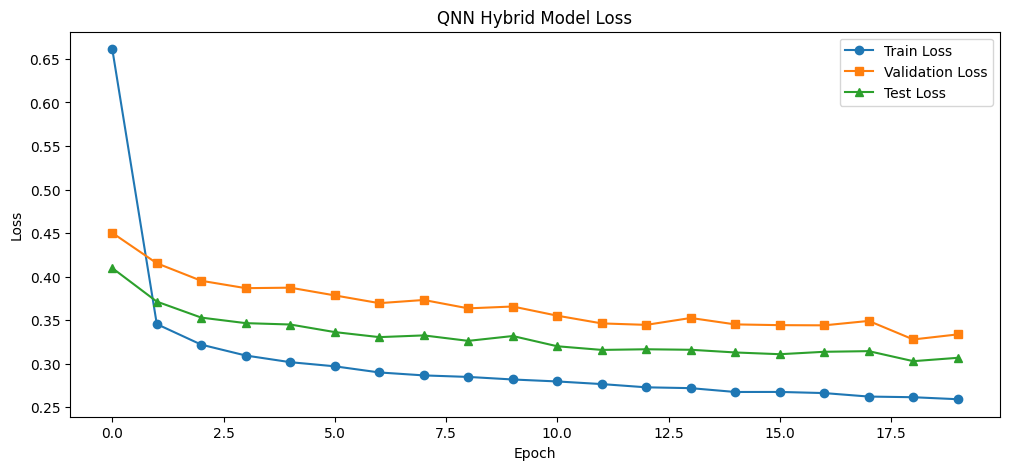

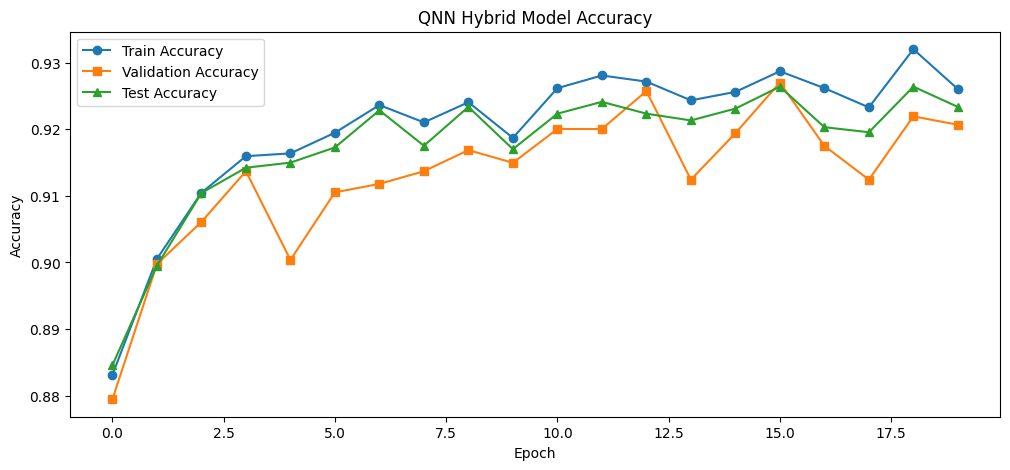

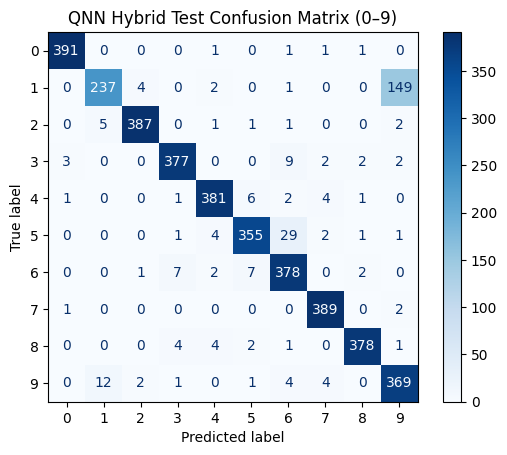

In [8]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# -------------------- Training Setup --------------------
epochs = 20
batch_size = 32
lr = 0.01
checkpoint = "checkpoint.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Validation split (10% of training data)
num_samples = X_train_t.shape[0]
val_ratio = 0.1
val_size = int(val_ratio * num_samples)
X_val_t = X_train_t[:val_size]
y_val_t = y_train_t[:val_size]
X_train_t_new = X_train_t[val_size:]
y_train_t_new = y_train_t[val_size:]
num_train_samples = X_train_t_new.shape[0]

# Resume from checkpoint if exists
if os.path.exists(checkpoint):
    checkpoint_data = torch.load(checkpoint)
    model.load_state_dict(checkpoint_data["model_state"])
    optimizer.load_state_dict(checkpoint_data["optimizer_state"])
    train_losses = checkpoint_data["train_losses"]
    val_losses = checkpoint_data["val_losses"]
    test_losses = checkpoint_data["test_losses"]
    train_accs = checkpoint_data["train_accs"]
    val_accs = checkpoint_data["val_accs"]
    test_accs = checkpoint_data["test_accs"]
    start_epoch = checkpoint_data["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 1

# -------------------- Training Loop --------------------
for ep in range(start_epoch, epochs + 1):
    model.train()
    epoch_loss = 0

    for i in tqdm(range(0, num_train_samples, batch_size), desc=f"Epoch {ep}/{epochs}"):
        X_batch = X_train_t_new[i:i + batch_size]
        y_batch = y_train_t_new[i:i + batch_size]

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / (num_train_samples // batch_size)
    train_losses.append(avg_train_loss)

    # Compute training accuracy
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_t_new).argmax(dim=1).numpy()
    train_acc = accuracy_score(y_train_t_new.numpy(), train_preds)
    train_accs.append(train_acc)

    # -------------------- Validation --------------------
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = loss_fn(val_logits, y_val_t).item()
        val_preds = val_logits.argmax(dim=1).numpy()
        val_acc = accuracy_score(y_val_t.numpy(), val_preds)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # -------------------- Test --------------------
    with torch.no_grad():
        test_logits = model(X_test_t)
        test_loss = loss_fn(test_logits, torch.tensor(y_test_np, dtype=torch.long)).item()
        test_preds = test_logits.argmax(dim=1).numpy()
        test_acc = accuracy_score(y_test_np, test_preds)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {ep}/{epochs} — "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    # Save checkpoint
    torch.save({
        "epoch": ep,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_accs": test_accs
    }, checkpoint)

# -------------------- Plotting --------------------
plt.figure(figsize=(12,5))
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='s', label='Validation Loss')
plt.plot(test_losses, marker='^', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("QNN Hybrid Model Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(train_accs, marker='o', label='Train Accuracy')
plt.plot(val_accs, marker='s', label='Validation Accuracy')
plt.plot(test_accs, marker='^', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("QNN Hybrid Model Accuracy")
plt.legend()
plt.show()

# -------------------- Final Test Confusion Matrix --------------------
model.eval()
with torch.no_grad():
    final_test_preds = model(X_test_t).argmax(dim=1).numpy()

cm = confusion_matrix(y_test_np, final_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("QNN Hybrid Test Confusion Matrix (0–9)")
plt.show()